In [1]:
import numpy as np
import numpy.random as npr
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook
import math
import os
import sys
sys.path.append('../')
from DataDefs.data import get_data

os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.set_default_dtype(torch.float32)
%matplotlib inline

In [2]:
class MLP(nn.Module):
    """
    Multilayer perceptron with a variable amount of hidden layers
    """
    def __init__(self, dims, activation='relu', bn=False, cuda=False):
        """
        Constructor for MLP with a variable number of hidden layers
        :param dims: A list of N tuples where the first N -1 determine the N - 1 hidden layers and the last tuple
        determines the output layer
        :param activation: a string that determines which activation layer to use. The default is relu
        """
        super().__init__()
        self.numHiddenLayers = len(dims[:-1])  # number of hidden layers in the network
        self.bn = bn
        modules = []
        for idx in range(len(dims) - 1):
            modules.append(nn.Linear(dims[idx][0], dims[idx][1]))
            if activation == 'relu':
                modules.append(nn.ReLU())
            else:
                modules.append(nn.Tanh())
            if bn:
                modules.append(nn.BatchNorm1d(dims[idx][1]))
        modules.append(nn.Linear(dims[-1][0], dims[-1][1]))
        self.sequential = nn.Sequential(*modules)
        self.max_neurons = max([dims[n][1] for n in range(self.numHiddenLayers)])

    def forward(self, x):
#         x = x.view(x.size(0), -1)
        # TODO vectorize inputs
        return self.sequential(x)

# Importance of maintaining good representation throughout the network
We will do 2 experiments.
The first experiment will investigate the negative effects of rapid decay by first performing PCA on the inputs and then passing them to the network.
The next one will pass the inputs through a basis funcition where each basis is highly concentrated on a specific training example, which will mimick slow decay (should be near uniform).

In [3]:
"Load in data"
train_loader, test_loader, full_loader = get_data(dataset='MNIST', batch_size=256, _seed=0,
                                                  validate=False, data_dir='../MNIST/')
X_full, _ = next(iter(full_loader))

# Fast decay

In [4]:
"Get basis for PCA"
print(X_full.shape)
print(X_full.squeeze(1).shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 28, 28])


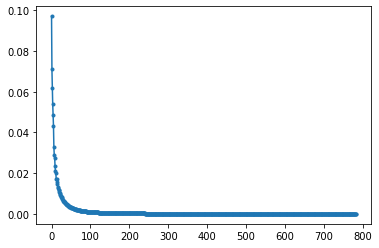

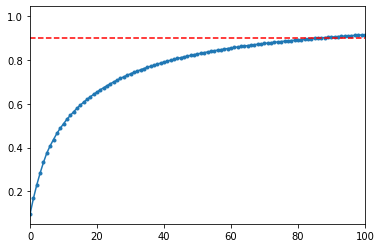

In [5]:
from numpy import newaxis as na
temp = X_full.reshape(-1, 28 * 28).numpy()
temp = temp - np.mean(temp, 0)[na, :]  # demean
cov = temp.T @ temp / (60_000 - 1)   # compute emperical covariance
cov = (cov + cov.T) / 2  # numerical stability
mnist_eig, mnist_vecs = np.linalg.eigh(cov)
mnist_eig = mnist_eig[::-1]
mnist_vecs = mnist_vecs[:, ::-1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mnist_eig / np.sum(mnist_eig), marker='.')
fig.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.cumsum(mnist_eig / np.sum(mnist_eig)), marker='.')
ax.plot(np.arange(28 * 28), 0.9 * np.ones(28 * 28), color='red', linestyle='--')
ax.set_xlim([0, 100])
fig.show()


In [6]:
d_project = 20
C = mnist_vecs[:, :d_project]
C = torch.from_numpy(C.copy())
# C = C.float()
print(C.shape)

torch.Size([784, 20])


In [7]:
num_epochs = 100

model_dims = [(d_project, 1_000), (1_000, 1_000), (1_000, 1_000), (1_000, 10)]
fast_model = MLP(dims=model_dims, bn=True, activation='tanh')

In [8]:
optim = torch.optim.Adam(fast_model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm_notebook(range(num_epochs)):
    for _, (x, y) in enumerate(tqdm_notebook(train_loader, desc="Training Batches",
                                             ascii=True, position=1, leave=True)):
        optim.zero_grad()
        xt = x.squeeze(1).reshape(-1, 28 * 28)
        x_project = xt @ C
        ell = loss(fast_model(x_project), y)
        ell.backward()
        optim.step()

In [ ]:
x_boring, _ = next(iter(train_loader))
print(x_boring.shape)
x_boring = x_boring.squeeze(1).reshape(-1, 28 * 28)
print(x_boring.shape)
x_boring = x_boring @ C
print(x_boring.shape)
